# Galton Height dataset analysis

Dataset downloaded from [Harvard Dataverse](https://doi.org/10.7910/DVN/T0HSJ1)

<em>"This is the famous Galton data on the heights or parents and their children (i.e., where the term 'regression' comes from)."</em>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load dataset
df = pd.read_csv('data/galton-stata11.tab', sep='\t')
df

,family,father,mother,gender,height,kids,male,female
0,1,78.5,67.0,M,73.2,4,1.0,0.0
1,1,78.5,67.0,F,69.2,4,0.0,1.0
2,1,78.5,67.0,F,69.0,4,0.0,1.0
3,1,78.5,67.0,F,69.0,4,0.0,1.0
4,2,75.5,66.5,M,73.5,4,1.0,0.0
...,...,...,...,...,...,...,...,...
893,136A,68.5,65.0,M,68.5,8,1.0,0.0
894,136A,68.5,65.0,M,67.7,8,1.0,0.0
895,136A,68.5,65.0,F,64.0,8,0.0,1.0
896,136A,68.5,65.0,F,63.5,8,0.0,1.0


## Dataset analysis
Performing first analysis on the dataset by:
* checking for missing data.
* visualising.
* adequating for further modeling.

In [3]:
# Checking missing data
df.isnull().any()

family    False
father    False
mother    False
gender    False
height    False
kids      False
male      False
female    False
dtype: bool

We can see from the table above there's no missing data in any column.

In [4]:
df.describe()

,father,mother,height,kids,male,female
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000
mean,69.232851,64.084410,66.760690,6.135857,0.517817,0.482183
std,2.470256,2.307025,3.582918,2.685156,0.499961,0.499961
min,62.000000,58.000000,56.000000,1.000000,0.000000,0.000000
25%,68.000000,63.000000,64.000000,4.000000,0.000000,0.000000
50%,69.000000,64.000000,66.500000,6.000000,1.000000,0.000000
75%,71.000000,65.500000,69.700000,8.000000,1.000000,1.000000
max,78.500000,70.500000,79.000000,15.000000,1.000000,1.000000


[]

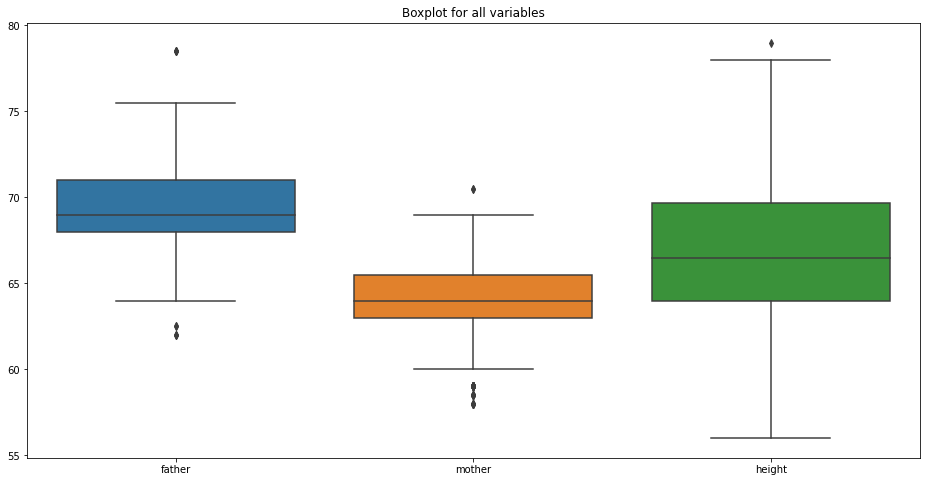

In [5]:
# showing the boxplot for all variables (except Date and Time)
plt.figure(figsize=(16,8))
sns.boxplot(data=df.loc[:, 'father':'height']).set_title("Boxplot for all variables")
plt.plot()

By the description of the data, according to the sample that Galton studied, fathers are, on average, `5.1 inches` taller than mothers. <br>

The boxplot shows that clearly and also the trend of children to have, on average, the height among the one of the parents.

We have a few outliers, however, they are not that far from the heights measured an shouldn't get any special attention.

To adequate better the data we'll put the gender information in only one column and drop the separate 'male' and 'female' columns.

In [6]:
# create column gender
df['gender'] = df['female'].astype(int)

# drop columns 'male' and 'female'
df.drop(columns=['male', 'female'], inplace=True)

df.head()

,family,father,mother,gender,height,kids
0,1,78.5,67.0,0,73.2,4
1,1,78.5,67.0,1,69.2,4
2,1,78.5,67.0,1,69.0,4
3,1,78.5,67.0,1,69.0,4
4,2,75.5,66.5,0,73.5,4


From now on, on the column `gender` we have the identifiers as `0 for male` and `1 for female`.

[]

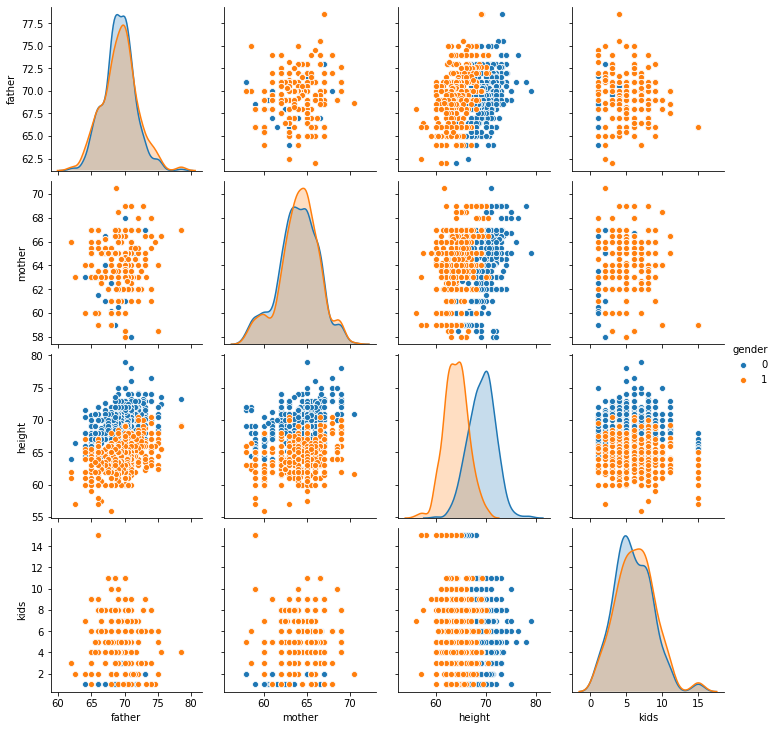

In [7]:
sns.pairplot(data=df, hue='gender')
plt.plot()

In [8]:
df.corr()['height']

father    0.275355
mother    0.201655
gender   -0.714258
height    1.000000
kids     -0.126910
Name: height, dtype: float64

The pairwise relationship in the dataset shows some correlation of the height with the father and mother's heights. It also seems to depend heavily on the gender.

## Frequentist analysis

## Bayesian analysis

In [9]:
import pymc3 as pm
import arviz as az

In [10]:
with pm.Model() as model:
    alpha_f = 1.0/df['father'].mean()
    alpha_m = 1.0/df['mother'].mean()
     
    a = pm.Exponential('father', lam=1.0)
    b = pm.Exponential('mother', lam=1.0)
    c = pm.Uniform("gender")
    d = pm.Normal('d', sd=10)
    
    sd = pm.HalfCauchy('sd', beta=1)
    
    link = a*df['father'].values + b*df['mother'].values + c*df['gender'] + d
    
    like = pm.Normal('height', mu=link, sd=sd, observed=df['height'].values)
    start = pm.find_MAP()

logp = -2,377, ||grad|| = 20.852: 100%|██████████| 80/80 [00:00<00:00, 2928.11it/s]     


In [11]:
with model:
    trace = pm.sample(1000, tune=2000, start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, d, gender, mother, father]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:49<00:00, 240.83draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f37d810bc90>,
      dtype=object)

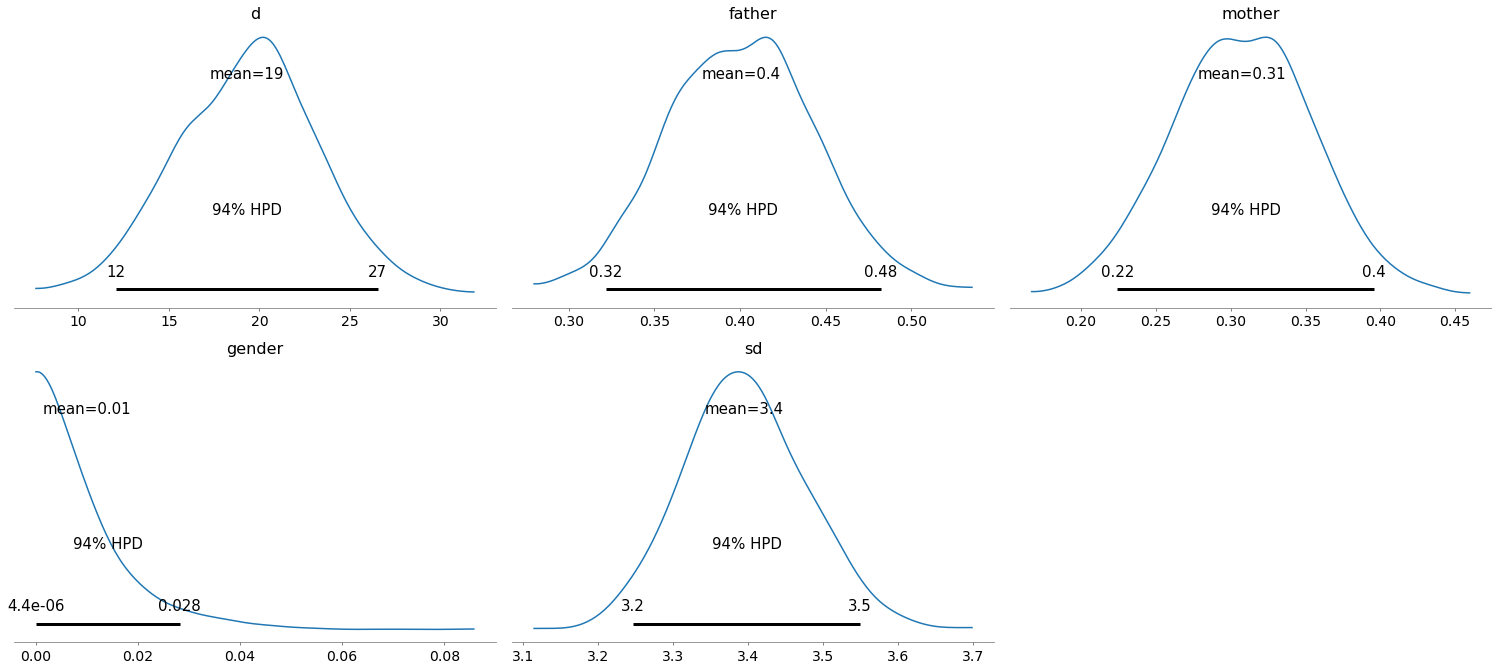

In [12]:
az.plot_posterior(trace[500:])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f37d06ad490>,
      dtype=object)

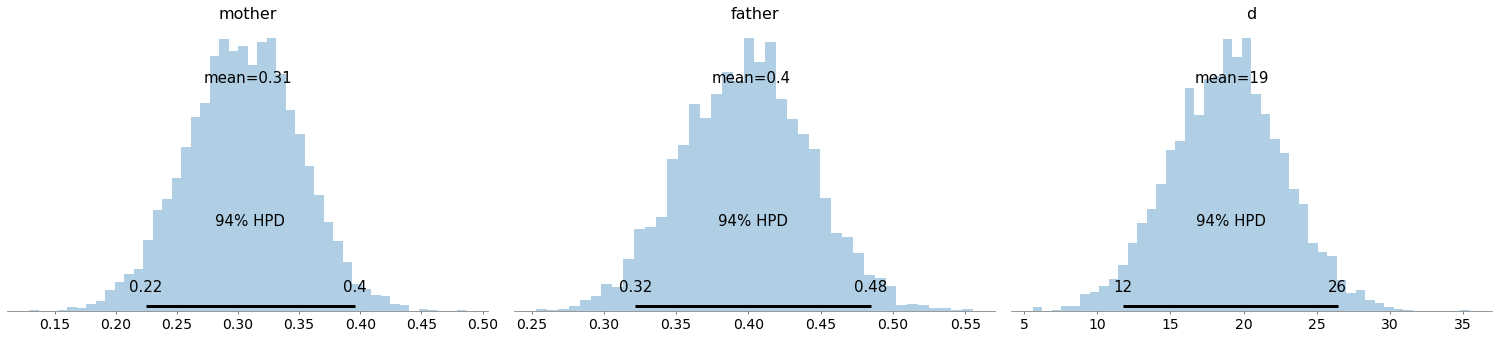

In [13]:
az.plot_posterior(trace, var_names=['mother','father','d'], kind='hist')